# Formula 1 Modelling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px

from scripts.ds_ultils import *

from scripts.model_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest

In [ ]:
#warning this takes 287 minutes to run!!!
# thats over 6 hours
file='./data/clean/combined_ergast_clean.csv'
qualify_df=pull_clean_aggregate_telemetry(file)

In [3]:
# save the dataframe
# qualify_df.to_pickle('./data/model_data/formula1_complete_2018_2022.pkl',compression='gzip')

In [2]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022.pkl',compression='gzip')

In [3]:
print(f'The complete database has this many nan rows {qualify_df.isna().any(axis=1).sum()}')
print(f'The nans are {round(qualify_df.isna().any(axis=1).sum()/len(qualify_df),2)}% of the data')

The complete database has this many nan rows 42
The nans are 0.02% of the data


These nans come from lack of car telemetry data. Who has the most Nan's?

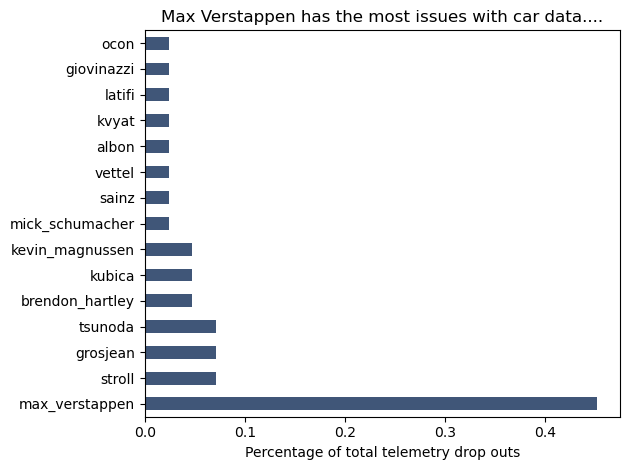

In [4]:
per_nan = qualify_df.loc[(qualify_df.isna().any(axis=1)),'driverRef'].value_counts()/len(qualify_df.loc[(qualify_df.isna().any(axis=1))])
plt.figure()
per_nan.plot(kind='barh')
plt.title('Max Verstappen has the most issues with car data....')
plt.xlabel('Percentage of total telemetry drop outs')
plt.tight_layout()
plt.savefig('./images/verstappend_nans.jpg',dpi=300)
plt.show()

In [5]:
qualifying_df=qualify_df.copy()

In [6]:
qualifying_df.dropna(inplace=True)

In [7]:
display_df=qualify_df.copy()
display_df.dropna(inplace=True)

In [8]:
display_df = convert_object_to_float(display_df)

In [9]:
display_df = engineer_target_bin(display_df)

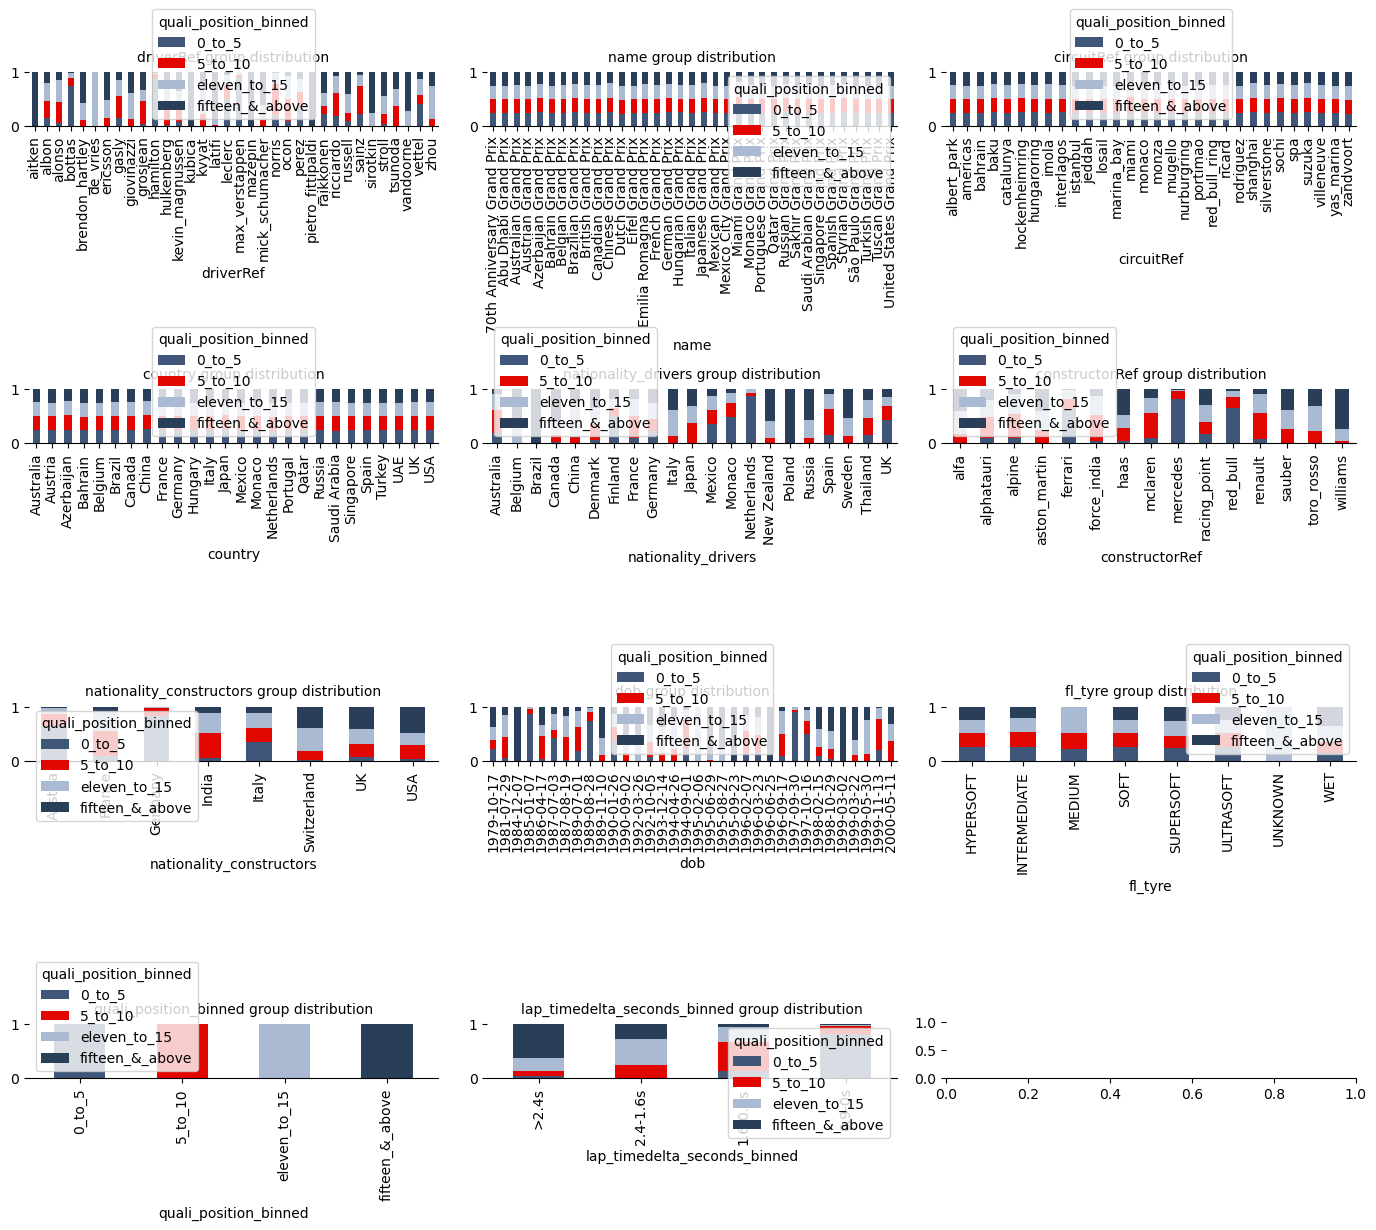

In [10]:
plot_categorical_cols_by_dim(display_df,'quali_position_binned',columns=3)

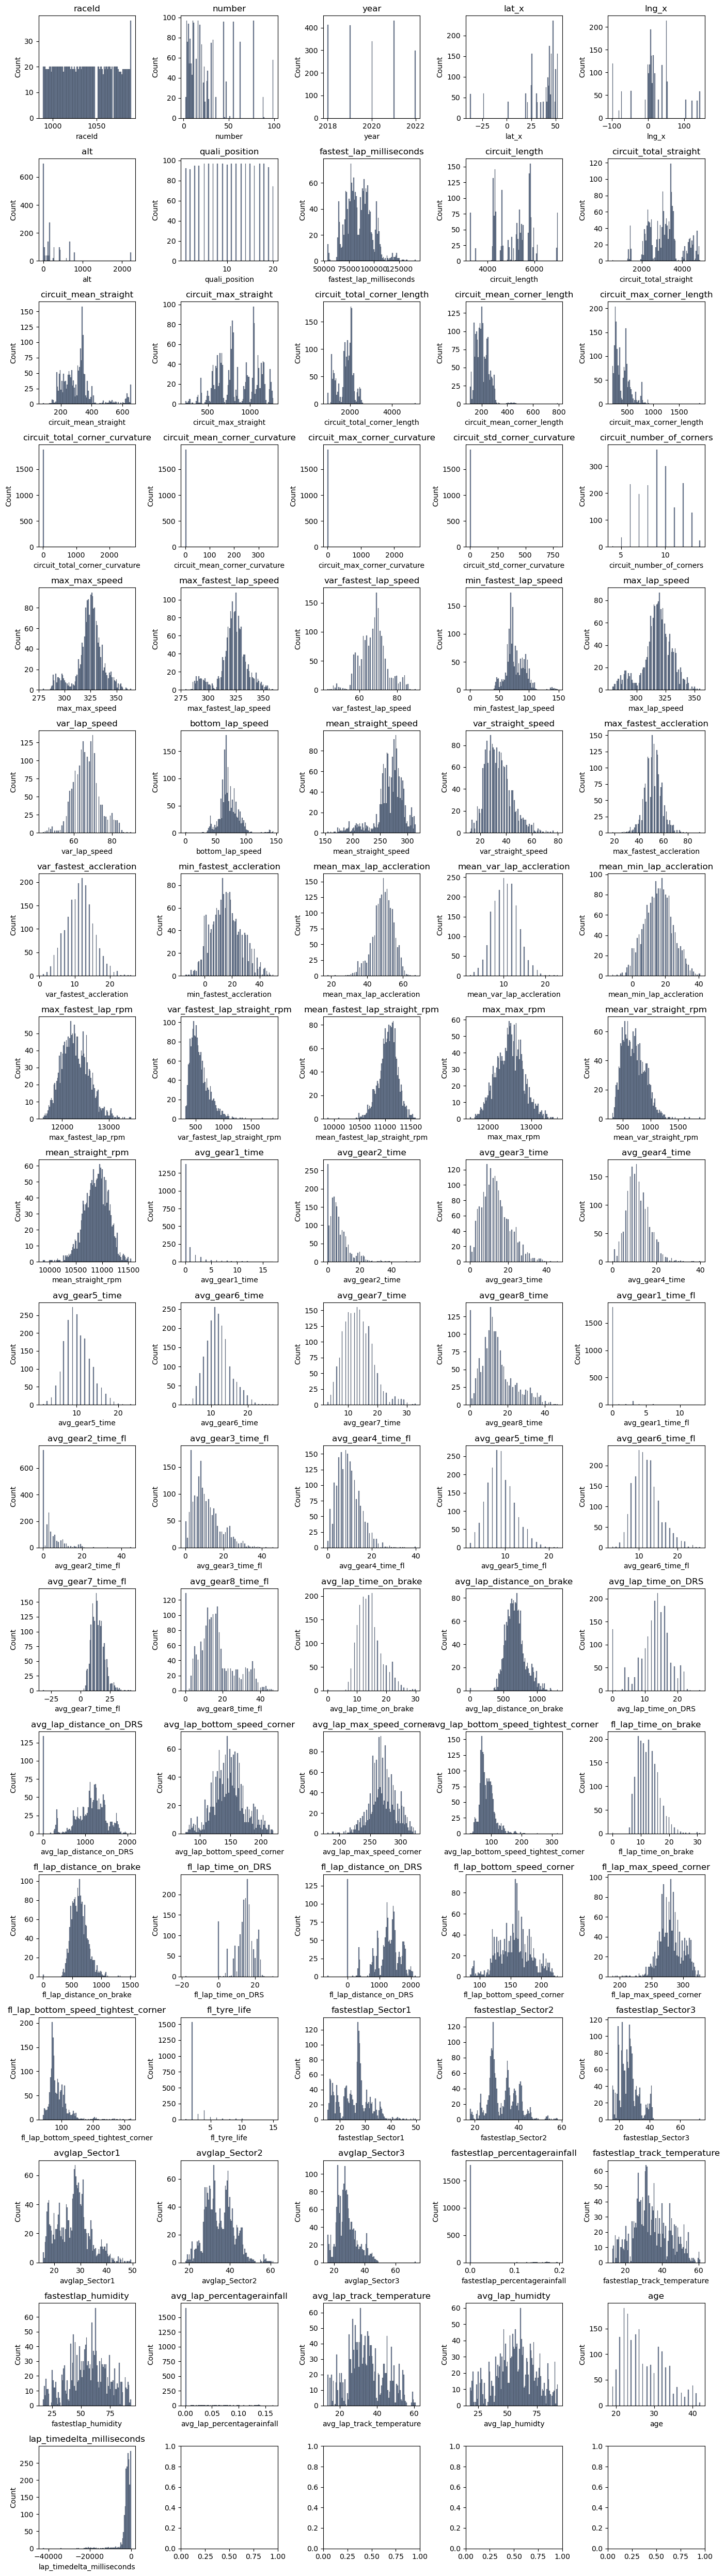

In [11]:
plot_numerical_variables_hist(display_df)

## Prepare for modelling

In [13]:
X_test, X_train, y_test, y_train = prepare_modelling_df(qualifying_df)

In [14]:
print(f'percentage test data is {(len(X_test)/len(X_train))*100}')

percentage test data is 11.536197763390229


In [15]:
hot_encode_col=list(X_train.select_dtypes("object").columns)
scale_cols = [col for col in X_train.columns if col not in hot_encode_col]

In [16]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
col_transform = ColumnTransformer(transformers=transformer)  
col_transform

ColumnTransformer(transformers=[('numerical_transform', StandardScaler(),
                                 ['year', 'lat_x', 'lng_x', 'alt',
                                  'circuit_length', 'circuit_total_straight',
                                  'circuit_mean_straight',
                                  'circuit_max_straight',
                                  'circuit_total_corner_length',
                                  'circuit_mean_corner_length',
                                  'circuit_max_corner_length',
                                  'circuit_total_corner_curvature',
                                  'circuit_mean_corner_curvature',
                                  'circui...
                                  'min_fastest_lap_speed', 'max_lap_speed',
                                  'var_lap_speed', 'bottom_lap_speed',
                                  'mean_straight_speed', 'var_straight_speed',
                                  'max_fastest_accleration',
                                  'var_fastest_accleration',
                                  'min_fastest_accleration',
                                  'mean_max_lap_accleration',
                                  'mean_var_lap_accleration', ...]),
                                ('hot_encode',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['driverRef', 'circuitRef', 'constructorRef',
                                  'fl_tyre'])])

In [17]:
X_train_scaled_demonstration = pd.DataFrame(data=col_transform.fit_transform(X_train),columns=col_transform.get_feature_names_out())
X_train_scaled_demonstration.head()

,numerical_transform__year,numerical_transform__lat_x,numerical_transform__lng_x,numerical_transform__alt,numerical_transform__circuit_length,numerical_transform__circuit_total_straight,numerical_transform__circuit_mean_straight,numerical_transform__circuit_max_straight,numerical_transform__circuit_total_corner_length,numerical_transform__circuit_mean_corner_length,...,hot_encode__constructorRef_toro_rosso,hot_encode__constructorRef_williams,hot_encode__fl_tyre_HYPERSOFT,hot_encode__fl_tyre_INTERMEDIATE,hot_encode__fl_tyre_MEDIUM,hot_encode__fl_tyre_SOFT,hot_encode__fl_tyre_SUPERSOFT,hot_encode__fl_tyre_ULTRASOFT,hot_encode__fl_tyre_UNKNOWN,hot_encode__fl_tyre_WET
0,1.527166,-4.212347,2.677668,-0.561039,0.114333,0.388426,-0.066048,0.186577,-0.750859,-0.940791,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.527166,-4.212347,2.677668,-0.561039,0.098057,0.389637,-0.075266,0.272158,-0.750859,-0.959978,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.527166,-4.212347,2.677668,-0.561039,0.108520,0.392060,-0.038393,0.520344,-0.690277,-0.940791,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.527166,-4.212347,2.677668,-0.561039,0.096894,0.341186,-0.075266,0.349181,-0.679741,-0.921604,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.527166,-4.212347,2.677668,-0.561039,0.114333,0.359355,-0.149013,-0.301238,-0.650767,-0.883230,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['lap_timedelta_seconds_binned'])
ydelta_train= labelencoder.transform(y_train['lap_timedelta_seconds_binned'])
ydelta_test= labelencoder.transform(y_test['lap_timedelta_seconds_binned'])

In [19]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['quali_position_binned'])
ypos_train= labelencoder.transform(y_train['quali_position_binned'])
ypos_test= labelencoder.transform(y_test['quali_position_binned'])

In [20]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
      
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [21]:
rf_model= forest_pipe.fit(X_train,ypos_train)

In [22]:
RF_results = pd.DataFrame(data=rf_model['random_forest'].feature_importances_ ,index=rf_model['column_transform'].get_feature_names_out())

In [23]:
RF_results.rename(columns={0:'Random_forest_result'},inplace=True)

In [24]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

select_k_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
      
        ('select_k',SelectKBest())# classifier
        
]
select_pipe=Pipeline(select_k_estimator)

In [25]:
sel_model=select_pipe.fit(X_train,ypos_train)

In [26]:
select_results = pd.DataFrame(data=sel_model['select_k'].scores_ ,index=sel_model['column_transform'].get_feature_names_out())
select_results.rename(columns={0:'SelectKbest_result'},inplace=True)

In [27]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

pca_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
      
        ('pca',PCA(n_components=0.9))# classifier
        
]
pca_pipe=Pipeline(pca_estimator)

In [28]:
pca_model=pca_pipe.fit(X_train,ypos_train)

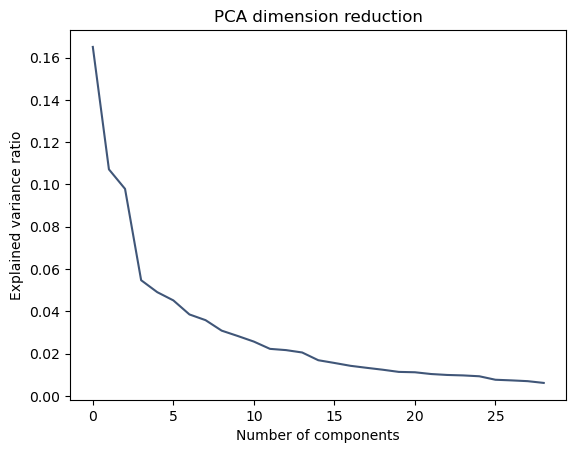

In [29]:
plt.figure()
plt.plot(np.arange(0,pca_model['pca'].n_components_,1),pca_model['pca'].explained_variance_ratio_)
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of components')
plt.title('PCA dimension reduction')
plt.show()

In [30]:
len(pca_model['pca'].explained_variance_)

29

In [31]:
pca_results = pd.DataFrame(data=pca_model['pca'].components_[0:2],columns=pca_model['column_transform'].get_feature_names_out(),index=['PCA1','PCA2'])

In [32]:
all_results = pd.concat([RF_results,select_results,pca_results.T.abs()],axis=1)
scaler=StandardScaler()
all_results_scaled = scaler.fit_transform(all_results)
all_results_2 = pd.DataFrame(data=all_results_scaled,index=all_results.index,columns=all_results.columns)

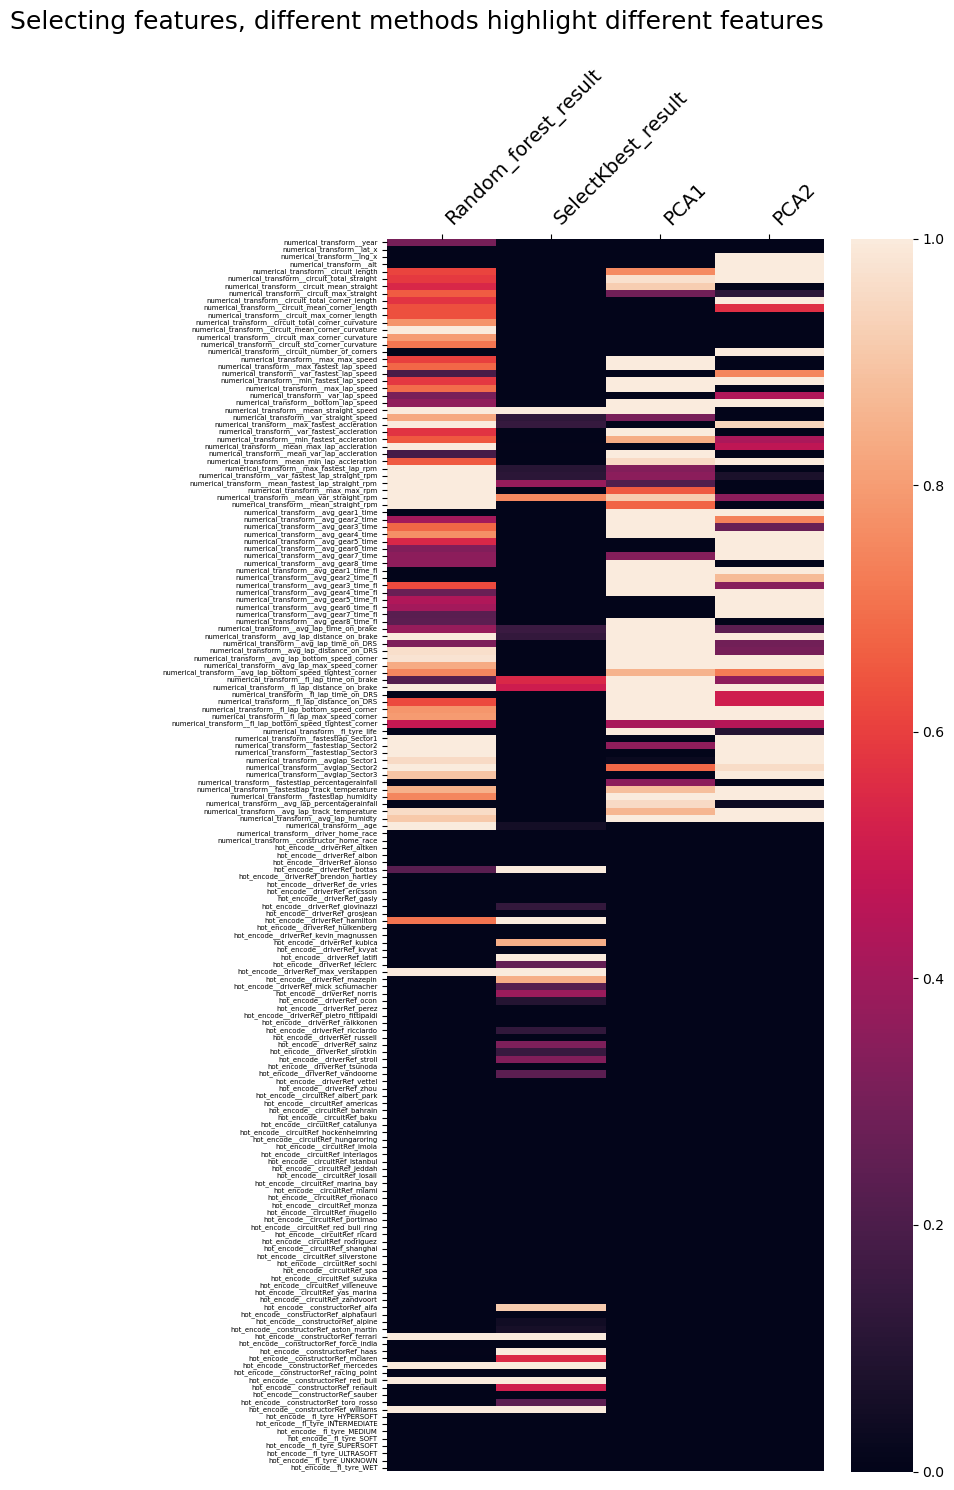

In [33]:
plt.figure(figsize=(8,15))
sns.heatmap(all_results_2, vmax=1, vmin=0)

plt.gca().xaxis.tick_top()
plt.title('Selecting features, different methods highlight different features\n',loc='right',fontsize=18)
plt.xticks(rotation = 45,ha='left',fontsize=14)
plt.yticks(np.arange(0.5,(len(all_results_2.index)+0.5)),labels=all_results_2.index,va="center",fontsize=5)
#plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.tight_layout()
plt.savefig('./images/feature_selection_all_data_full.jpg',dpi=300,bbox_inches='tight')
plt.show()

In [34]:
print(f'Vanilla starting Random Forest Score is {rf_model.score(X_test,ypos_test)}')

Vanilla starting Random Forest Score is 0.5561224489795918


In [35]:
manual_features = list(RF_results[all_results_2['Random_forest_result']>0.8].index)

In [36]:
features_remove =[ 'numerical_transform__avglap_Sector1',
 'numerical_transform__avglap_Sector2',
 'numerical_transform__avglap_Sector3',
 'numerical_transform__max_max_rpm',
 'numerical_transform__mean_var_straight_rpm',
 'numerical_transform__mean_straight_rpm',
 'hot_encode__driverRef_hamilton',
 'hot_encode__driverRef_max_verstappen',
 'hot_encode__constructorRef_ferrari',
 'hot_encode__constructorRef_mercedes',
 'hot_encode__constructorRef_red_bull',
 'hot_encode__constructorRef_williams',
 'hot_encode__driverRef_bottas'
 ]

In [37]:
manual_features = [x for x in manual_features if x not in features_remove]

In [38]:
len(manual_features)

20

## Manual Features

In [39]:
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [40]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [41]:
rf_model= forest_pipe.fit(X_train_manual,ypos_train)

In [42]:
print(f' Initial train score with selected featuers {rf_model.score(X_train_manual,ypos_train)}')
print(f' Initial test score with selected feaure {rf_model.score(X_test_manual,ypos_test)}')

 Initial train score with selected featuers 1.0
 Initial test score with selected feaure 0.45408163265306123


In [43]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

logisitic_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        
        ('random_forest',LogisticRegression())# classifier
        
]
log_pipe=Pipeline(logisitic_estimator)

In [44]:
log_model= log_pipe.fit(X_train_manual,ypos_train)
print(f' Initial train score with selected featuers {log_model.score(X_train_manual,ypos_train)}')
print(f' Initial test score with selected feaure {log_model.score(X_test_manual,ypos_test)}')

 Initial train score with selected featuers 0.42319011183048855
 Initial test score with selected feaure 0.4387755102040816


## PCA dimension reduction

In [45]:
scale_cols, hot_encode_col = column_lists(X_train)

In [46]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        ('pca', PCA()),
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [48]:
forest_pipe.set_params(pca__n_components=15)
forest_pipe.fit(X_train,ypos_train)
print(f' Initial train score with selected featuers {forest_pipe.score(X_train,ypos_train)}')
print(f' Initial test score with selected feaure {forest_pipe.score(X_test,ypos_test)}')

 Initial train score with selected featuers 1.0
 Initial test score with selected feaure 0.3112244897959184
